In [ ]:
https://scikit-learn.org/stable/modules/mixture.html
https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_sin.html#sphx-glr-auto-examples-mixture-plot-gmm-sin-py
https://scikit-learn.org/stable/auto_examples/mixture/plot_concentration_prior.html#sphx-glr-auto-examples-mixture-plot-concentration-prior-py
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html#sklearn.mixture.BayesianGaussianMixture
https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py
https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html 
https://www.geeksforgeeks.org/ml-variational-bayesian-inference-for-gaussian-mixture/
    

'full' (each component has its own general covariance matrix),
'tied' (all components share the same general covariance matrix),
'diag' (each component has its own diagonal covariance matrix),
'spherical' (each component has its own single variance).

fnl_columns=pd.DataFrame(fnl_data.columns)
fnl_columns= fnl_columns.rename(columns={0:'Columns'})
fnl_columns['Check']=1
fnl_columns

data= pd.read_excel('/Users/aleksandr/Desktop/rpl_for_model.xlsx')

data_columns = pd.DataFrame(data.columns)
data_columns = data_columns.rename(columns={0:'Columns'})
data_columns
comparing = data_columns.merge(fnl_columns, how='left', on='Columns')
comparing

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice. As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works as a density estimator, not how well it works as a clustering algorithm. I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('classic')
import seaborn as sns; sns.set(style='white')
%matplotlib inline
from sklearn import decomposition
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
sns.set()
import matplotlib.cm as cm
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
from gap_statistic import OptimalK
from datetime import datetime
from datetime import date



In [395]:
rpl_data= pd.read_excel('/Users/aleksandr/Desktop/rpl_for_model.xlsx')
fnl_general = pd.read_excel('/Users/aleksandr/Desktop/diplom/FNL_general.xlsx')
fnl_passing = pd.read_csv('/Users/aleksandr/Desktop/diplom/FNL_passing.csv')
fnl_data=fnl_general.merge(fnl_passing,how='left', on='Player')
data= rpl_data.append(fnl_data)



In [396]:
data=data.drop(['xG per 90', 'xA per 90', 'Interceptions per 90'],axis=1)
data=data.drop(['xG.1','xA per 90.1', 'xA.1'],axis=1)
data=data[data['Position']!='GK']
data=data[data['Market value']!=0]
data=data[data['Minutes played']>90]
data = data.reset_index()
data = data.reset_index()
data=data.drop(['level_0', 'index'],axis=1)
player=data['Player']
target=data['Market value']
add_info=data[['Player', 'Market value', 'Team', 'Matches played', 'Minutes played', 'On loan']]
data=data.drop(['Player', 'Market value', 'Team', 'Matches played', 'Minutes played', 'On loan','Assists per 90.1'],axis=1)

In [397]:
columns_names = []
for col in data.columns:
    columns_names.append(col)
    
cols_no_mean=['Position','Age', 'Contract expires', 'Birth country', 'Passport country', 'Foot', 'Height']
columns_names_mean= [x for x in columns_names if x not in cols_no_mean]
for i in data[columns_names_mean]:
    data[i] = data[i].fillna(data[i].mean(), inplace=False)
for i in data[cols_no_mean]:
    data[i] = data[i].fillna(0)    

In [398]:
network_metrics = data[['total_passes_closeness', 'total_passes_betw', 'total_passes_pagerank',
       'total_passes_transitivity', 'forward_passes_closeness',
       'forward_passes_betw', 'forward_passes_pagerank',
       'forward_passes_transitivity', 'back_passes_closeness',
       'back_passes_betw', 'back_passes_pagerank', 'back_passes_transitivity',
       'long_passes_closeness', 'long_passes_betw', 'long_passes_pagerank',
       'long_passes_transitivity', 'final_3rd_passes_closeness',
       'final_3rd_passes_betw', 'final_3rd_passes_pagerank',
       'final_3rd_passes_transitivity', 'progressive_passes_closeness',
       'progressive_passes_betw', 'progressive_passes_pagerank','progressive_passes_transitivity']]
#scaler = StandardScaler()
#scaler.fit(network_metrics)
#network_metrics_scaled = scaler.transform(network_metrics)
scaler = MinMaxScaler()  
scaler.fit(network_metrics)
network_metrics_scaled= scaler.transform(network_metrics)

In [399]:
optimalK = OptimalK(parallel_backend='joblib')
optimalK

OptimalK(n_jobs=4, parallel_backend="joblib")

In [400]:
n_clusters= optimalK(network_metrics_scaled, cluster_array=np.arange(1, 50))
n_clusters

46

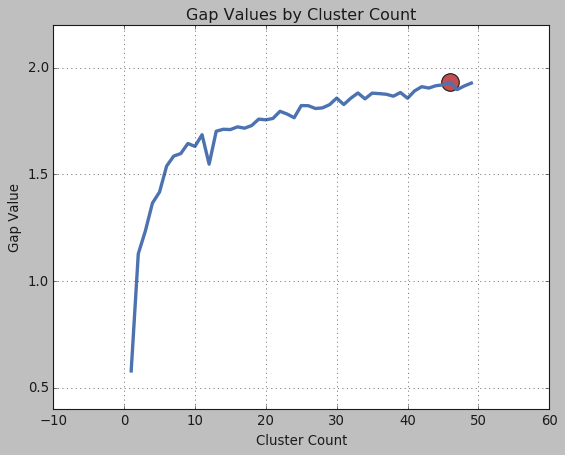

In [401]:
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [402]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=5, random_state=42)
roles_clusters= kmeans.fit_predict(network_metrics_scaled)
data['roles_clusters'] = roles_clusters
#data = pd.get_dummies(data, columns=['roles_clusters'])

In [403]:
data=data.drop(['total_passes_closeness', 'total_passes_betw', 'total_passes_pagerank',
       'total_passes_transitivity', 'forward_passes_closeness',
       'forward_passes_betw', 'forward_passes_pagerank',
       'forward_passes_transitivity', 'back_passes_closeness',
       'back_passes_betw', 'back_passes_pagerank', 'back_passes_transitivity',
       'long_passes_closeness', 'long_passes_betw', 'long_passes_pagerank',
       'long_passes_transitivity', 'final_3rd_passes_closeness',
       'final_3rd_passes_betw', 'final_3rd_passes_pagerank',
       'final_3rd_passes_transitivity', 'progressive_passes_closeness',
       'progressive_passes_betw', 'progressive_passes_pagerank',
       'progressive_passes_transitivity'],axis=1)

In [404]:
data['shots on target per 90'] = data['Shots per 90'] * data['Shots on target %']
data['Dribbles succ. per 90'] = data['Dribbles per 90'] * data['Dribbles succ. %']
data['Def duels won per 90'] = data['Def duels per 90'] * data['Def duels won %']
data['Aerial duels won per 90'] = data['Aerial duels per 90'] * data['Aerial duels won %']
data['Tackle succ per 90'] = data['Tackles per 90'] * data['Tackle succ. %']
data['Smt passes acc. per 90'] = data['Smt passes per 90'] * data['Smt passes acc. %']
data['Final 3rd passes acc per90'] = data['Final 3rd passes per 90'] * data['Final 3rd passes acc. %']
data['Thru passes acc per 90'] = data['Thru passes per 90'] * data['Thru passes acc. %']
data['Deep completed passes acc per 90'] = data['Deep completed passes per 90'] * data['Deep completed passes acc. %']
data['Deep completed crosses acc per 90'] = data['Deep completed crosses per 90'] * data['Deep completed crosses acc. %']
data['Passes acc per 90'] = data['Passes per 90'] * data['Passes acc. %']
data['Fwd passes acc per 90'] = data['Fwd passes per 90'] * data['Fwd passes acc. %']
data['Back passes acc'] = data['Back passes per 90'] * data['Back passes acc. %']
data['Lat passes acc'] = data['Lat passes per 90'] * data['Lat passes acc. %']
data['Lng passes acc'] = data['Lng passes per 90'] * data['Lng passes acc. %']

In [405]:
data=data.drop(['Shots per 90','Shots on target %', 'Dribbles per 90', 'Dribbles succ. %',
               'Def duels per 90', 'Def duels won %','Aerial duels per 90','Aerial duels won %',
               'Tackles per 90', 'Tackle succ. %', 'Smt passes per 90', 'Smt passes acc. %', 'Final 3rd passes per 90',
               'Final 3rd passes acc. %','Thru passes per 90', 'Thru passes acc. %', 'Deep completed passes per 90', 
               'Deep completed passes acc. %','Deep completed crosses per 90',  'Deep completed crosses acc. %', 
               'Passes per 90','Passes acc. %','Fwd passes per 90',  'Fwd passes acc. %',  'Back passes per 90',
               'Back passes acc. %','Lat passes per 90', 'Lat passes acc. %','Lng passes per 90', 'Lng passes acc. %'],axis=1)

In [406]:
data['Contract expires'] = data['Contract expires'].replace(0,pd.to_datetime('today') )
data['Contract expires'] = pd.to_datetime(data['Contract expires'])
data['Contract length']= (data['Contract expires'] - pd.to_datetime('today')).astype('timedelta64[D]')
data['Contract length'] = data['Contract length'].replace(-1, 0)
data = data.drop(['Contract expires'],axis=1)

In [407]:
dropped_features = [['Fouls per 90', 'Yellow cards', 'Yellow cards per 90','Red cards', 'Height',
                'Weight','Non-penalty goals', 'Age', 'Goals total','Tackles per opp.30','Interceptions per opp.30',
               'Avg pass length. m', 'Avg lng pass length. m', 'Non-penalty goals per 90','Head goals total','Assists',
               'Shots total', 'xG', 'Red cards per 90', 'Succ. att. actions',
               'Goal conv.. %', 'xA', 'Crosses. %', 'Passes to penalty area acc. %',
               'Back passes acc', 'Lat passes acc', 'Lng passes acc', 'Contract length']]
data=data.drop(['Fouls per 90', 'Yellow cards', 'Yellow cards per 90','Red cards', 'Height',
                'Weight','Non-penalty goals', 'Age', 'Goals total','Tackles per opp.30','Interceptions per opp.30',
               'Avg pass length. m', 'Avg lng pass length. m', 'Non-penalty goals per 90','Head goals total','Assists',
               'Shots total', 'xG', 'Red cards per 90', 'Succ. att. actions',
               'Goal conv.. %', 'xA', 'Crosses. %', 'Passes to penalty area acc. %',
               'Back passes acc', 'Lat passes acc', 'Lng passes acc', 'Contract length'],axis=1)

In [408]:
def recode_nation(column):
    if column == 'Russia':
        return 1
    if column == 'Armenia':
        return 1
    if column == 'Kyrgyzstan':
        return 1
    if column == 'Kazakhstan':
        return 1
    if column == 'Ukraine':
        return 1
    else:
        return 0
    
    
data['Birth country'] =data['Birth country'].apply(recode_nation) 
data['Passport country'] =data['Passport country'].apply(recode_nation)
#data = pd.get_dummies(data, columns=['Position', 'Birth country', 'Passport country', 'Foot'])
position = data['Position']
data=data.drop(['Position'],axis=1)
#data = pd.get_dummies(data, columns=[ 'Birth country', 'Passport country', 'Foot'])
data=data.drop(['Birth country', 'Passport country', 'Foot'],axis=1)

In [409]:
data.shape

(765, 26)

In [410]:
data.head(1)

Goals per 90  Head goals per 90  Assists per 90  Crosses per 90  \
0           0.0                0.0             0.0             0.0   

   Touches in box per 90  Progressive runs per 90  Succ. def. per 90  \
0                   4.09                     1.02               3.07   

   Shots blocked per 90  Second assists per 90  Third assists per 90  \
0                   0.0                    0.0                   0.0   

   Key passes per 90  Passes to penalty area per 90  \
0                0.0                           1.02   

   Progressive passes per 90  roles_clusters  shots on target per 90  \
0                       2.05              11                  102.25   

   Dribbles succ. per 90  Def duels won per 90  Aerial duels won per 90  \
0                  306.6                 613.5                    102.2   

   Tackle succ per 90  Smt passes acc. per 90  Final 3rd passes acc per90  \
0                 0.0                     0.0                         0.0   

   Thru passes acc per 90  Deep completed passes acc per 90  \
0                     0.0                               0.0   

   Deep completed crosses acc per 90  Passes acc per 90  Fwd passes acc per 90  
0                                0.0            1738.25                  102.0

In [411]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

In [412]:

scaler = MinMaxScaler()  
scaler.fit(data)
data_scaled= scaler.transform(data)

#scaler = StandardScaler()
#scaler.fit(data)
#data_scaled = scaler.transform(data)

#data_scaled = preprocessing.Normalizer().fit(data)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [413]:
n_clusters= optimalK(data_scaled, cluster_array=np.arange(1, 50))
n_clusters

47

In [414]:
##k, gapdf = optimalK(data_scaled, nrefs=5, maxClusters=50)
##print(k)

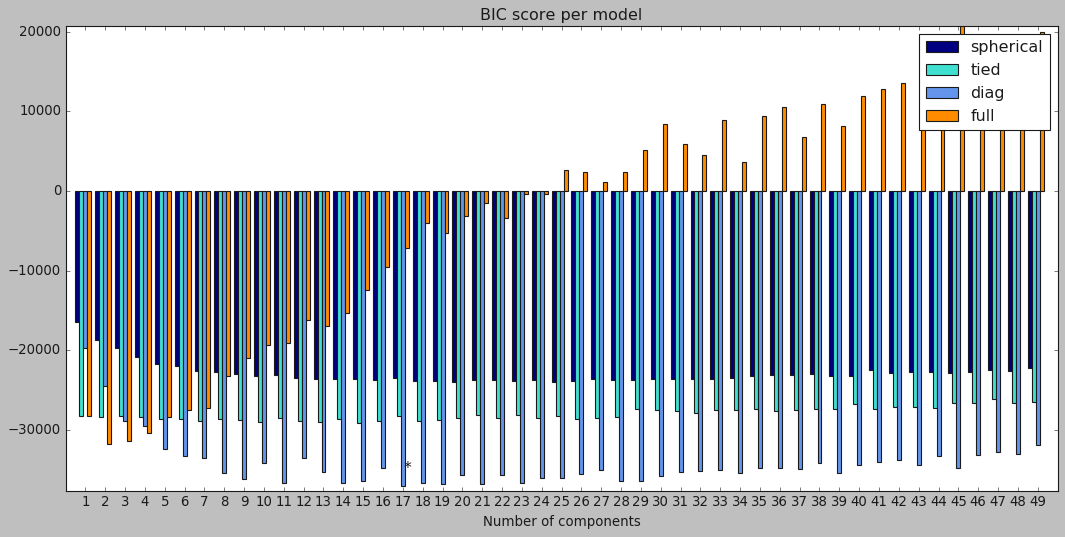

In [415]:
import numpy as np
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture
mpl.style.use('classic')



X = data_scaled
lowest_bic = np.infty
bic = []
n_components_range = range(1, 50)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(16, 16))
plt.grid(True)
plt.style.use('classic')
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)



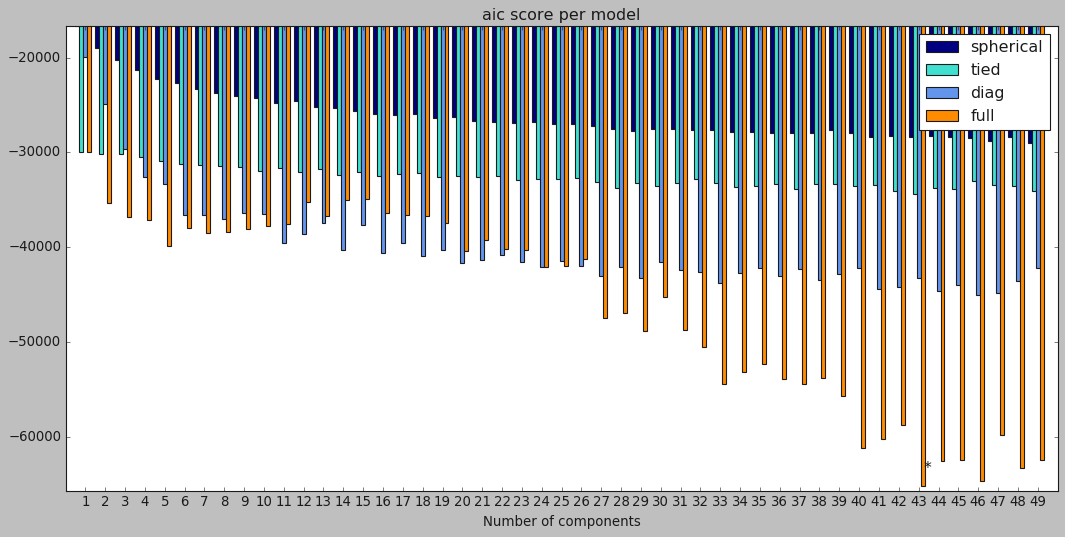

In [416]:
lowest_aic = np.infty
aic = []
n_components_range = range(1, 50)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        aic.append(gmm.aic(X))
        if aic[-1] < lowest_aic:
            lowest_aic = aic[-1]
            best_gmm = gmm

aic = np.array(aic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the aic scores
plt.figure(figsize=(16, 16))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, aic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([aic.min() * 1.01 - .01 * aic.max(), aic.max()])
plt.title('aic score per model')
xpos = np.mod(aic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(aic.argmin() / len(n_components_range))
plt.text(xpos, aic.min() * 0.97 + .03 * aic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)



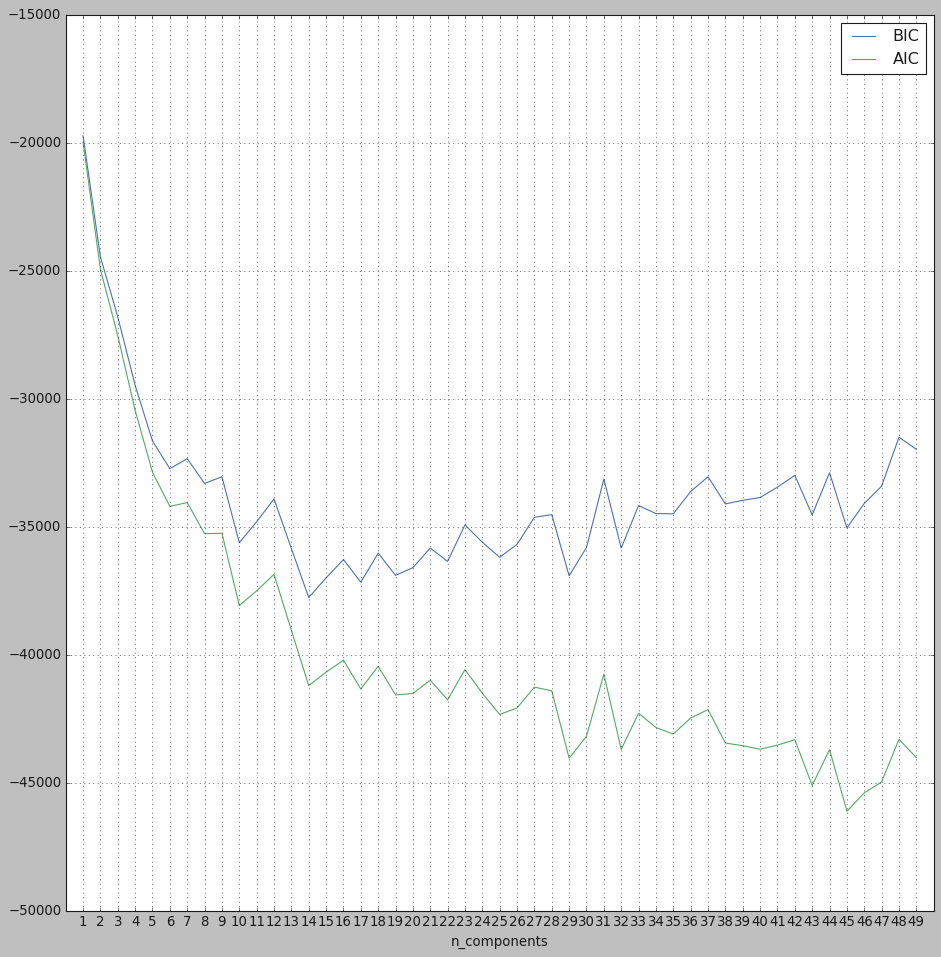

In [417]:
n_components = np.arange(1, 50)
models = [GaussianMixture(n, covariance_type='diag', random_state=42).fit(data_scaled) for n in n_components]
plt.figure(figsize=(14, 14))
plt.plot(n_components, [m.bic(data_scaled) for m in models], label='BIC')
plt.plot(n_components, [m.aic(data_scaled) for m in models], label='AIC')
plt.grid(True)
plt.style.use('classic')
plt.xticks(np.arange(1, 50))
plt.legend(loc='best')
plt.xlabel('n_components');

In [421]:
gmm = GaussianMixture(covariance_type='diag', n_components=14,max_iter=5000, random_state=42, init_params='kmeans')
gmm.fit(data_scaled)
labels = gmm.predict_proba(data_scaled)
cluster_results = pd.DataFrame(labels).round(decimals=3)
cluster_results['Player'] = player

In [422]:
cluster_results

0      1      2      3      4      5      6      7      8      9  \
0    0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000   
1    0.000  0.008  0.000  0.000  0.000  0.000  0.000  0.586  0.000  0.405   
2    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
3    0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000   
4    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.992   
5    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000   
6    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
7    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.022   
8    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
9    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
10   1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
11   0.000  0.000  0.000  0.009  0.000  0.000  0.000  0.020  0.000  0.000   
12   0.000  0.000  0.000  0.000  0.000  0.076  0.000  0.000  0.000  0.000   
13   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
14   0.998  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.002  0.000   
15   0.000  0.000  0.000  0.000  0.933  0.000  0.000  0.000  0.000  0.067   
16   1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
17   0.000  0.996  0.000  0.000  0.000  0.000  0.004  0.000  0.000  0.000   
18   0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000   
19   1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
20   0.000  0.000  0.000  0.000  0.998  0.000  0.000  0.000  0.002  0.000   
21   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.852  0.000  0.000   
22   0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000   
23   0.000  0.006  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.006   
24   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
25   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000   
26   0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
27   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
28   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.002   
29   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000   
30   0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000   
31   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
32   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
33   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000   
34   0.000  0.998  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
35   0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
36   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
37   0.000  0.000  0.971  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
38   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.011  0.000  0.989   
39   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
40   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.008   
41   0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000   
42   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
43   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
44   0.945  0.000  0.000  0.001  0.000  0.000  0.000  0.000  0.054  0.000   
45   0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000   
46   0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000   
47   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
48   0.989  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.011   
49   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.091   
50   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.002   
51   

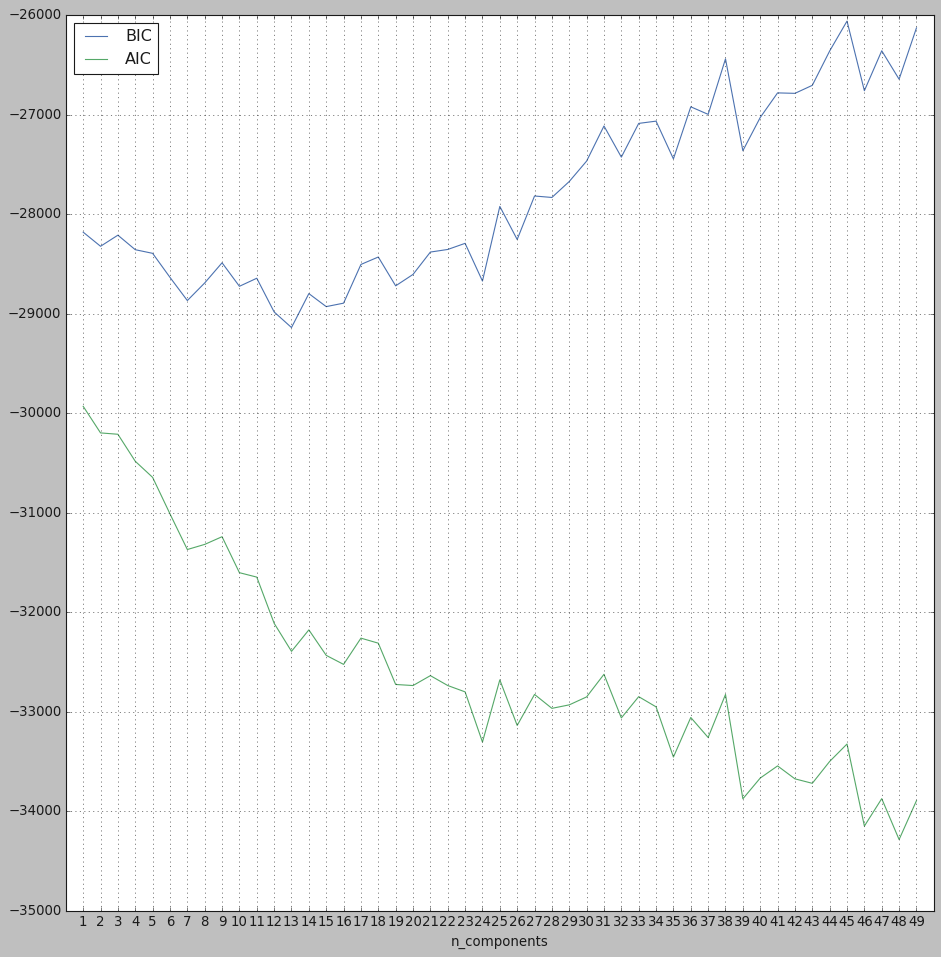

In [420]:
n_components = np.arange(1, 50)
models = [GaussianMixture(n, covariance_type='tied', random_state=42).fit(data_scaled) for n in n_components]
plt.figure(figsize=(14, 14))
plt.plot(n_components, [m.bic(data_scaled) for m in models], label='BIC')
plt.plot(n_components, [m.aic(data_scaled) for m in models], label='AIC')
plt.grid(True)
plt.style.use('classic')
plt.xticks(np.arange(1, 50))
plt.legend(loc='best')
plt.xlabel('n_components');

In [423]:
gmm = GaussianMixture(covariance_type='tied', n_components=16,max_iter=5000, random_state=42, init_params='kmeans')
gmm.fit(data_scaled)
labels2 = gmm.predict_proba(data_scaled)
cluster_results2 = pd.DataFrame(labels2).round(decimals=3)
cluster_results2['Player'] = player

In [424]:
cluster_results2

0      1      2      3      4      5      6      7      8      9  \
0    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
1    0.303  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
2    0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.000   
3    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
4    0.843  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
5    0.000  0.000  0.000  0.000  0.000  0.997  0.000  0.000  0.000  0.000   
6    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
7    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
8    0.000  0.000  0.000  0.000  0.984  0.000  0.000  0.000  0.000  0.000   
9    0.000  0.000  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
10   0.000  0.000  0.000  0.000  0.999  0.000  0.000  0.000  0.001  0.000   
11   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
12   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
13   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
14   0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000   
15   0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.286  0.000   
16   0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.000  0.000   
17   0.000  0.000  0.000  0.000  0.000  0.000  0.988  0.000  0.000  0.000   
18   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
19   0.000  0.000  0.000  0.000  0.000  0.990  0.000  0.000  0.000  0.000   
20   0.000  0.000  0.000  0.000  0.003  0.000  0.000  0.000  0.948  0.000   
21   0.002  0.000  0.001  0.000  0.000  0.000  0.004  0.000  0.000  0.000   
22   0.000  0.000  0.000  0.000  0.000  0.000  0.090  0.000  0.000  0.000   
23   0.000  0.000  0.000  0.000  0.000  0.984  0.000  0.000  0.000  0.000   
24   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
25   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
26   0.000  0.000  0.977  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
27   0.844  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
28   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
29   0.022  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
30   0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.000  0.000   
31   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
32   0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000   
33   0.000  0.000  0.000  0.000  0.000  0.002  0.000  0.000  0.000  0.000   
34   0.000  0.000  0.000  0.000  0.000  0.000  0.047  0.000  0.000  0.000   
35   0.000  0.000  0.000  0.000  0.000  0.000  0.999  0.000  0.000  0.000   
36   0.000  0.000  0.624  0.000  0.000  0.000  0.006  0.000  0.000  0.001   
37   0.001  0.000  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
38   0.997  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
39   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
40   0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000   
41   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
42   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
43   0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
44   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
45   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
46   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000   
47   0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000   
48   0.000  0.000  0.000  0.000  0.000  0.000  0.008  0.000  0.861  0.000   
49   0.030  0.000  0.002  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
50   0.000  0.000  0.000  0.000  0.000  0.087  0.000  0.000  0.000  0.024   
51   

In [425]:
from sklearn.mixture import BayesianGaussianMixture
GBM = BayesianGaussianMixture(n_components=14,  covariance_type='diag',weight_concentration_prior_type='dirichlet_process' ,init_params='kmeans')
GBM.fit(data_scaled)
labels3 = GBM.predict_proba(data_scaled)
cluster_results3 = pd.DataFrame(labels3).round(decimals=3)
cluster_results3['Player'] = player

In [426]:
cluster_results3 

0    1      2      3    4      5      6    7      8      9   10   11  \
0    0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  1.000  0.0  0.0   
1    0.998  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.002  0.000  0.0  0.0   
2    0.250  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  0.750  0.0  0.0   
3    0.000  0.0  0.000  0.000  0.0  1.000  0.000  0.0  0.000  0.000  0.0  0.0   
4    0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  1.000  0.0  0.0   
5    0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  1.000  0.0  0.0   
6    0.000  0.0  0.000  0.000  0.0  1.000  0.000  0.0  0.000  0.000  0.0  0.0   
7    0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  1.000  0.000  0.0  0.0   
8    0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  1.000  0.000  0.0  0.0   
9    0.950  0.0  0.000  0.000  0.0  0.028  0.000  0.0  0.000  0.021  0.0  0.0   
10   0.000  0.0  0.000  0.000  0.0  0.000  0.941  0.0  0.059  0.000  0.0  0.0   
11   1.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.0   
12   0.001  0.0  0.000  0.000  0.0  0.999  0.000  0.0  0.000  0.000  0.0  0.0   
13   0.998  0.0  0.000  0.000  0.0  0.000  0.001  0.0  0.000  0.000  0.0  0.0   
14   0.000  0.0  0.000  0.000  0.0  0.000  1.000  0.0  0.000  0.000  0.0  0.0   
15   0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  1.000  0.0  0.0   
16   0.000  0.0  0.000  0.000  0.0  0.000  0.942  0.0  0.058  0.000  0.0  0.0   
17   0.000  0.0  0.000  1.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.0   
18   0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  1.000  0.0  0.0   
19   1.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.0   
20   0.000  0.0  1.000  0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.0   
21   1.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.0   
22   0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  1.000  0.0  0.0   
23   0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  1.000  0.0  0.0   
24   0.000  0.0  0.000  0.000  0.0  1.000  0.000  0.0  0.000  0.000  0.0  0.0   
25   0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  1.000  0.000  0.0  0.0   
26   0.000  0.0  0.000  0.000  0.0  1.000  0.000  0.0  0.000  0.000  0.0  0.0   
27   0.000  0.0  0.000  0.000  0.0  0.999  0.000  0.0  0.000  0.001  0.0  0.0   
28   0.020  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  0.980  0.0  0.0   
29   0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  1.000  0.000  0.0  0.0   
30   1.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.0   
31   0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  1.000  0.000  0.0  0.0   
32   0.000  0.0  0.000  1.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.0   
33   0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  1.000  0.0  0.0   
34   0.849  0.0  0.000  0.000  0.0  0.000  0.149  0.0  0.000  0.002  0.0  0.0   
35   1.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.0   
36   1.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.0   
37   0.002  0.0  0.000  0.000  0.0  0.998  0.000  0.0  0.000  0.000  0.0  0.0   
38   0.999  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  0.001  0.0  0.0   
39   0.998  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  0.002  0.0  0.0   
40   0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  1.000  0.0  0.0   
41   0.000  0.0  0.000  0.000  0.0  0.000  0.002  0.0  0.000  0.998  0.0  0.0   
42   1.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.0   
43   0.000  0.0  0.000  0.000  0.0  0.998  0.000  0.0  0.000  0.002  0.0  0.0   
44   0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.0   
45   0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.000  1.000  0.0  0.0   
46   0.000  0.0  1.000  0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  0.0   
47   0.000  0.0  0.000  0.000  0.0  0.000  0.000  0.0  1.000  0.000  0.0  0.0   
48   0.000  0.0  0.000  0.000  0.0  0.00

In [427]:
from sklearn.mixture import BayesianGaussianMixture
GBM = BayesianGaussianMixture(n_components=16,  covariance_type='tied',weight_concentration_prior_type='dirichlet_process',init_params='kmeans' )
GBM.fit(data_scaled)
labels4 = GBM.predict_proba(data_scaled)
cluster_results4 = pd.DataFrame(labels4).round(decimals=3)
cluster_results4['Player'] = player

/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [428]:
cluster_results4

0      1      2      3      4      5      6      7      8      9  \
0    0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000   
1    0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000   
2    0.000  0.000  0.892  0.000  0.000  0.001  0.000  0.000  0.000  0.000   
3    0.000  0.000  0.964  0.000  0.000  0.000  0.000  0.000  0.036  0.000   
4    0.000  0.837  0.161  0.002  0.000  0.000  0.000  0.000  0.000  0.000   
5    0.000  0.997  0.003  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
6    0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
7    0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000   
8    0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.999  0.000  0.000   
9    0.000  0.000  0.611  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
10   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
11   0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
12   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
13   0.000  0.000  0.999  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
14   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
15   0.998  0.000  0.002  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
16   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
17   0.000  0.000  0.001  0.000  0.000  0.999  0.000  0.000  0.000  0.000   
18   0.000  0.001  0.993  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
19   0.000  0.997  0.003  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
20   0.999  0.000  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
21   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
22   0.000  0.001  0.798  0.000  0.000  0.102  0.099  0.000  0.000  0.000   
23   0.000  0.991  0.007  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
24   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000   
25   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
26   0.000  0.000  0.002  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
27   0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
28   0.000  0.001  0.992  0.000  0.000  0.000  0.000  0.000  0.007  0.000   
29   0.000  0.000  0.000  0.015  0.000  0.000  0.000  0.985  0.000  0.000   
30   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
31   0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000   
32   0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000   
33   0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000   
34   0.000  0.070  0.891  0.000  0.000  0.039  0.000  0.000  0.000  0.000   
35   0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000   
36   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
37   0.000  0.000  0.993  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
38   0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000   
39   0.000  0.000  0.977  0.000  0.000  0.000  0.000  0.000  0.021  0.000   
40   0.000  0.990  0.010  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
41   0.000  0.001  0.863  0.000  0.000  0.000  0.136  0.000  0.000  0.000   
42   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
43   0.000  0.053  0.568  0.000  0.000  0.000  0.000  0.000  0.379  0.000   
44   0.000  0.015  0.985  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
45   0.000  0.000  0.120  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
46   1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
47   0.000  0.002  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.996   
48   0.987  0.000  0.007  0.000  0.000  0.005  0.000  0.000  0.000  0.000   
49   0.000  0.000  0.746  0.251  0.000  0.000  0.000  0.000  0.000  0.000   
50   0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
51   

In [434]:
BGM=BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_distribution",
        n_components=16,  covariance_type='tied',init_params='random')
     
     


In [436]:
BGM.fit(data_scaled)
labels5 = BGM.predict_proba(data_scaled)
cluster_results5 = pd.DataFrame(labels5).round(decimals=3)
cluster_results5['Player'] = player

/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [437]:
cluster_results5

0      1      2      3      4      5      6      7    8      9  \
0    0.000  0.021  0.000  0.000  0.000  0.000  0.000  0.979  0.0  0.000   
1    0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.0  0.000   
2    0.000  0.151  0.000  0.000  0.000  0.000  0.001  0.000  0.0  0.000   
3    0.000  0.816  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
4    0.000  0.180  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
5    0.000  0.014  0.000  0.000  0.986  0.000  0.000  0.000  0.0  0.000   
6    0.000  0.994  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
7    0.000  0.000  0.000  0.998  0.000  0.000  0.000  0.000  0.0  0.000   
8    0.000  0.000  0.003  0.000  0.000  0.997  0.000  0.000  0.0  0.000   
9    0.000  0.345  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.603   
10   0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.0  0.000   
11   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
12   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.010   
13   0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
14   0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.0  0.000   
15   0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.0  0.000   
16   0.000  0.978  0.000  0.000  0.020  0.000  0.000  0.001  0.0  0.000   
17   0.000  0.002  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
18   0.000  0.998  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
19   0.000  0.002  0.000  0.000  0.013  0.000  0.000  0.000  0.0  0.000   
20   0.979  0.020  0.000  0.001  0.000  0.000  0.000  0.000  0.0  0.000   
21   0.000  0.005  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.995   
22   0.000  0.017  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
23   0.000  0.008  0.000  0.000  0.992  0.000  0.000  0.000  0.0  0.000   
24   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
25   0.000  0.005  0.000  0.000  0.000  0.000  0.995  0.000  0.0  0.000   
26   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.0  1.000   
27   0.000  0.143  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
28   0.000  0.998  0.000  0.000  0.000  0.000  0.002  0.000  0.0  0.000   
29   0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.0  0.000   
30   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
31   0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.0  0.000   
32   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
33   0.000  0.997  0.000  0.000  0.003  0.000  0.000  0.000  0.0  0.000   
34   0.000  0.968  0.001  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
35   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
36   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.996   
37   0.000  0.565  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.001   
38   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
39   0.000  0.995  0.000  0.000  0.000  0.000  0.001  0.000  0.0  0.000   
40   0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.0  0.000   
41   0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
42   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
43   0.000  0.006  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
44   0.000  0.998  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
45   0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
46   1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
47   0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.0  0.000   
48   0.747  0.079  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
49   0.000  0.968  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.001   
50   0.000  0.745  0.000  0.000  0.249  0.000  0.001  0.000  0.0  0.000   
51   0.000  0.000  0.000  0.000  0.902  0.000  0.000  0.000  0.0  0.000   
52   0.000  0.999  0.000  0.000  0

In [438]:
cluster_results5
BGM=BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_distribution",
        n_components=14,  covariance_type='diag',init_params='random',
        max_iter=5000)
     
BGM.fit(data_scaled)    
labels6 = BGM.predict_proba(data_scaled)
cluster_results6 = pd.DataFrame(labels6).round(decimals=3)
cluster_results6['Player'] = player

In [439]:
cluster_results6

0      1      2    3    4    5      6    7      8      9   10   11  \
0    0.007  0.018  0.975  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
1    0.000  0.000  0.800  0.0  0.0  0.0  0.200  0.0  0.000  0.000  0.0  0.0   
2    0.000  0.000  0.002  0.0  0.0  0.0  0.973  0.0  0.000  0.000  0.0  0.0   
3    0.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  1.000  0.0  0.0   
4    0.000  0.000  0.051  0.0  0.0  0.0  0.002  0.0  0.000  0.000  0.0  0.0   
5    0.000  0.000  1.000  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
6    0.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  1.000  0.0  0.0   
7    0.000  0.000  1.000  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
8    1.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
9    0.000  0.000  0.000  0.0  0.0  0.0  0.951  0.0  0.006  0.035  0.0  0.0   
10   1.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
11   0.000  0.000  0.011  0.0  0.0  0.0  0.989  0.0  0.000  0.000  0.0  0.0   
12   0.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  1.000  0.0  0.0   
13   0.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
14   1.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
15   0.836  0.000  0.164  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
16   1.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
17   0.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
18   0.000  0.999  0.001  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
19   0.000  0.000  0.000  0.0  0.0  0.0  1.000  0.0  0.000  0.000  0.0  0.0   
20   1.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
21   0.000  0.000  0.000  0.0  0.0  0.0  1.000  0.0  0.000  0.000  0.0  0.0   
22   0.001  0.002  0.385  0.0  0.0  0.0  0.000  0.0  0.000  0.001  0.0  0.0   
23   0.000  0.000  0.759  0.0  0.0  0.0  0.051  0.0  0.000  0.000  0.0  0.0   
24   0.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  1.000  0.0  0.0   
25   1.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
26   0.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  1.000  0.000  0.0  0.0   
27   0.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  1.000  0.0  0.0   
28   0.000  0.000  0.025  0.0  0.0  0.0  0.966  0.0  0.000  0.000  0.0  0.0   
29   0.001  0.000  0.999  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
30   0.000  0.000  0.000  0.0  0.0  0.0  1.000  0.0  0.000  0.000  0.0  0.0   
31   0.000  0.000  1.000  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
32   0.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  1.000  0.0  0.0   
33   0.004  0.000  0.996  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
34   0.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
35   0.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
36   0.000  0.000  0.000  0.0  0.0  0.0  1.000  0.0  0.000  0.000  0.0  0.0   
37   0.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  1.000  0.000  0.0  0.0   
38   0.000  0.000  0.222  0.0  0.0  0.0  0.778  0.0  0.000  0.000  0.0  0.0   
39   0.000  0.000  0.000  0.0  0.0  0.0  1.000  0.0  0.000  0.000  0.0  0.0   
40   0.000  0.000  0.981  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
41   0.000  1.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
42   0.000  0.000  0.000  0.0  0.0  0.0  1.000  0.0  0.000  0.000  0.0  0.0   
43   0.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  1.000  0.0  0.0   
44   0.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  0.000  1.0  0.0   
45   0.001  0.000  0.456  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
46   1.000  0.000  0.000  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
47   0.000  0.000  1.000  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
48   0.087  0.000  0.913  0.0  0.0  0.0  0.000  0.0  0.000  0.000  0.0  0.0   
49   0.000  0.000  0.015  0.0  0.0  0.0  0.983  0.0  0.000 

In [441]:
target = gmm.predict(data_scaled)
scaler = MinMaxScaler()  
scaler.fit(data)
data_scaled= scaler.transform(data)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Automatically created module for IPython interactive environment


/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


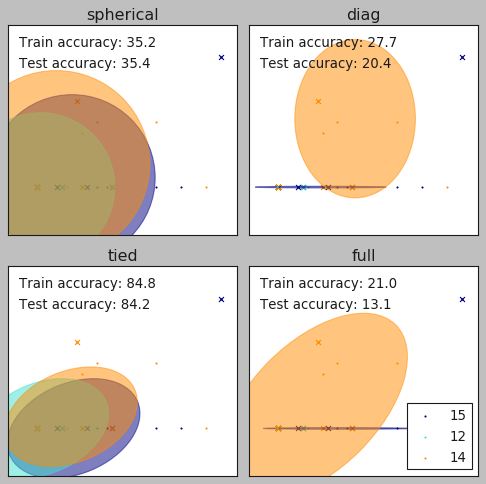

In [442]:
from sklearn.model_selection import StratifiedKFold

print(__doc__)

colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')



# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=3)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(data_scaled, target)))


X_train = data_scaled[train_index]
y_train = target[train_index]
X_test = data_scaled[test_index]
y_test = target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = data_scaled[target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=target[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()